# Solution to exercises for week 41-42
##### Brage Wiseth, Eirik Jahr, Felix Cameren


##### week 41

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression of the gradients

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate), again using the analytical expression of the gradients.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

##### week 42 same as week 41 but using automatic differentiation

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using automatic differentiation. Compare this with the analytical expression of the gradients you obtained last week. Feel free to use **Autograd** as Python package or **JAX**. You can use the examples form last week.

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Compare this with the analytical expression of the gradients you obtained last week.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD using automatic differentiation..

5. Add RMSprop and Adam to your library of methods for tuning the learning rate. Again using automatic differentiation.

## Data

jax backend gpu


Text(0.5, 1.0, 'Scatter plot of noisy data')

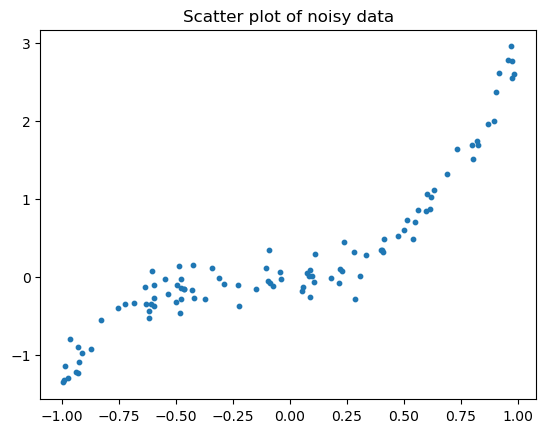

In [1463]:
import numpy as onp
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from functools import partial
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))


def f(x):
    return 0.2*x + 0.8*x**2 + 2*x**3

key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, shape=(100,), minval=-1, maxval=1)
key, subkey = jax.random.split(key)
y = f(x) + 0.15*jax.random.normal(subkey, shape=(100,))
plt.scatter(x, y, s=10)
plt.title("Scatter plot of noisy data")

## Preprocessing

In [1464]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

X = poly.fit_transform(x.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

## Methods
### Parent class for all methods

### Jit compiling functions
In hope of speeding up the code, the tradeoff is that the code is not as readable and organised

In [1465]:
@jax.jit
def MSE(y , t):
    return np.mean((y - t)**2)

@jax.jit
def MSE_Ridge(y, t, alpha, w):
    return np.mean((y - t)**2) + alpha*np.sum(w**2)



def print_message(message):
    print(f"\r{message: <100}", end='')



def gradients(X, t, params):
    w = params[0]['w']
    b = params[0]['b']
    y = np.dot(X , w) + b
    wgrad = (2/X.shape[0]) * np.dot(X.T , (y - t))
    bgrad = 2/X.shape[0] * np.sum(y - t)
    return [{'w': wgrad, 'b': bgrad}]


def ridge_gradients(X, t, w, alpha):
    return 2/X.shape[0] * X.T @ (X @ w - t) + 2*alpha*w


def backprop_gradients(X, t, params):
    w = params[0]['w']
    b = params[0]['b']
    y = np.dot(X , w) + b
    wgrad = (2/X.shape[0]) * np.dot(X.T , (y - t))
    bgrad = 2/X.shape[0] * np.sum(y - t)
    return [{'w': wgrad, 'b': bgrad}]



def init_network_params(layer_sizes, key):
    keys = jax.random.split(key, len(layer_sizes) - 1)
    return [{'w': jax.random.normal(k, (in_size, out_size)) * np.sqrt(2 / in_size),
             'b': np.zeros(out_size)}
            for k, in_size, out_size in zip(keys, layer_sizes[:-1], layer_sizes[1:])]






### Analytical

In [1466]:
class AnalyticalLinReg:
    def __init__(self):
        self.weights = None

    def score(self, X, t):
        return MSE(self.weights, X, t)

    def fit(self, X_train, t_train):
        self.weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ t_train

### Gradient descent with hessian matrix inverse (gets computationaly heavy real quick)

In [1467]:
def create_update_hessian(eta):
    def hessian(params, grads, state):
        hess = jax.jacfwd(jax.jacrev(MSE))(params, grads)
        
        return new_params, new_state

### Standard gradient descent (with optional momentum)

In [1468]:
def create_update_sgd(eta, gamma):
    def sgd_update(params, grads, state ):
        def update_one_param(param, grad, velocity):
            new_velocity = gamma * velocity + eta * grad
            new_param = param - new_velocity
            return new_param, new_velocity
                # Update all parameters and states separately
        new_params = jax.tree_map(
            lambda p, g, s: update_one_param(p, g, s)[0], params, grads, state
        )
        new_state = jax.tree_map(
            lambda p, g, s: update_one_param(p, g, s)[1], params, grads, state
        )
        return new_params, new_state
    return sgd_update




def init_SGD_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)



### Ridge gradient descent (with optional momentum)

In [1469]:
def create_update_ridge(eta, momentum, weight_decay):
    def ridge_update(params, grads, state):
        def update_one_param(param, grad, velocity):
            new_velocity = momentum * velocity + eta * grad + weight_decay * grad
            new_param = param - new_velocity
            return new_param, new_velocity
        new_params = jax.tree_map(
            lambda p, g, s: update_one_param(p, g, s)[0], params, grads, state
        )
        new_state = jax.tree_map(
            lambda p, g, s: update_one_param(p, g, s)[1], params, grads, state
        )
        return new_params, new_state
    return ridge_update

def init_ridge_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)



### Adagrad (with optional momentum)

In [1470]:
def create_update_adagrad(learning_rate, epsilon):
    def update(params, grads, state):
        new_state = jax.tree_multimap(
            lambda s, g: s + g ** 2,
            state, grads
        )
        new_params = jax.tree_multimap(
            lambda p, g, s: p - learning_rate * g / (np.sqrt(s) + epsilon),
            params, grads, new_state
        )
        return new_params, new_state
    
    return update

def init_adagrad_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)


### RMSprop

In [1471]:
def create_update_rmsprop(learning_rate, decay_rate, epsilon):
    def update(params, grads, state):
        new_state = jax.tree_multimap(
            lambda g, s: decay_rate * s + (1 - decay_rate) * g ** 2,
            grads, state
        )
        new_params = jax.tree_multimap(
            lambda p, g, s: p - learning_rate * g / (np.sqrt(s) + epsilon),
            params, grads, new_state
        )
        return new_params, new_state
    
    return update

def init_rmsprop_state(params):
    return jax.tree_map(lambda p: np.zeros_like(p), params)

### Adam

In [1472]:
def init_adam_state(params):
    ms = jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize first moment
    vs = jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize second moment
    ts = jax.tree_map(lambda p: np.zeros_like(p), params)  # Initialize time step
    return ms, vs, ts

def create_update_adam(eta=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    def adam_update(params, grads, state ):
        ms, vs, ts = state

        def update_one_param(param, m, v, t, grad):
            # Update biased first moment estimate
            m = beta1 * m + (1 - beta1) * grad
            # Update biased second raw moment estimate
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            # Compute bias-corrected first moment estimate
            m_hat = m / (1 - beta1 ** (t + 1))
            # Compute bias-corrected second raw moment estimate
            v_hat = v / (1 - beta2 ** (t + 1))
            # Update parameter
            new_param = param - eta * m_hat / (np.sqrt(v_hat) + epsilon)
            return new_param, m, v

        # Update all parameters and states
        new_params, new_ms, new_vs = jax.tree_multimap(update_one_param, params, ms, vs, ts, grads)
        new_ts = jax.tree_map(lambda t: t + 1, ts)  # Update time step
        return new_params, (new_ms, new_vs, new_ts)
    return adam_update

In [1473]:
def predict(params, X):
    return np.dot(X, params[0]['w']) + params[0]['b']


# Super class for all linear regression models
class NumpyLinReg():

    def __init__(self , eta=0.1, epochs=100, tol=0.001, optimizer='sgd', alpha=0, gamma=0, epsilon=0.0001, decay=0.9, beta1=0.9, beta2=0.999):
        self.eta = eta
        self.epochs = epochs
        self.tol = tol
        self.optimizer = optimizer
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2



    def init_optimizer(self, params):
        match self.optimizer:
            case 'sgd':
                optimizer = create_update_sgd(self.eta, self.gamma)
                optimizerState = init_SGD_state(params)
                return optimizer, optimizerState
            case 'rgd':
                optimizer = create_update_ridge(self.eta, self.gamma, self.alpha)
                optimizerState = init_ridge_state(params)
                return optimizer, optimizerState
            case 'adagrad':
                optimizer = create_update_adagrad(self.eta, self.epsilon, self.gamma)
                optimizerState = init_adagrad_state(params)
                return optimizer, optimizerState
            case 'rmsprop':
                optimizer = create_update_rmsprop(self.eta, self.epsilon, self.decay)
                optimizerState = init_rmsprop_state(params)
                return optimizer, optimizerState
            case 'adam':
                optimizer = create_update_adam(self.eta, self.beta1, self.beta2, self.epsilon)
                optimizerState = init_adam_state(params)
                return optimizer, optimizerState
            case 'hessian':
                optimizer = create_update_hessian(self.eta)
                optimizerState = init_hessian_state(params)
                return optimizer, optimizerState
            case _:
                raise ValueError(f"Unknown optimizer {self.optimizer}")



    def fit(self, X, t, X_val, t_val, batch_size=None ):
        (N, m) = X_train.shape
        if batch_size is None:
            batch_size = N
        key = jax.random.PRNGKey(1234)
        params = init_network_params([m, 1], key)
        update_params, opt_state = self.init_optimizer(params) 
        batches = int(N/batch_size)
        loss = np.zeros(self.epochs)

        @jax.jit
        def step(params, opt_state, X, t):
            grads = gradients(X, t, params)
            params, opt_state = update_params(params, grads, opt_state)
            return params, opt_state

        for e in range(self.epochs):
            for _ in range(batches):

                key, subkey = jax.random.split(key)
                random_index = batch_size * jax.random.randint(subkey, minval=0, maxval=batches, shape=())
                X_batch = X[random_index:random_index+batch_size]
                t_batch = t[random_index:random_index+batch_size]

                params, opt_state = step(params, opt_state, X_batch, t_batch)

                current_loss = MSE(self.predict(X_val, params), t_val)

                # clip gradients
                if not np.isfinite(current_loss).all():
                    params = jax.tree_map(lambda p: np.clip(p, -100, 100), params)

                loss = loss.at[e].set(current_loss)

                # Early stopping condition
                if e > 10 and np.abs(loss[e-10] - loss[e]) < self.tol:
                    loss = loss.at[e+1:].set(loss[e]) 
                    break


        print_message(f"Training stopped after {e} epochs")
        return loss , params




    def predict(self, X, params):
        return np.dot(X, params[0]['w']) + params[0]['b']


## Results

In [1474]:
etas = [ 0.0001, 0.001, 0.01, 0.1 ]
epochs =100
tol = 0.001
gammas = [0.0, 0.1, 0.5, 0.9]
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilon = 1e-8
decay = 0.9
beta1 = 0.9
beta2 = 0.999

def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    return f'Progress: [{arrow}{padding}] {int(fraction*100)}%'




def runGD():
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    scoresRidge = np.zeros((len(etas), len(gammas),len(alphas), epochs))
    for i, eta in enumerate(etas):
        for j, gamma in enumerate(gammas):
            sgd     =   NumpyLinReg(eta=eta, epochs=epochs, tol=tol, optimizer='sgd', gamma=gamma)
            loss, _ = sgd.fit(X_train, y_train, X_test, y_test)
            scoresSgd = scoresSgd.at[i,j,:].set(loss)
            print(progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
            for k, alpha in enumerate(alphas):
                ridgeGd     =  NumpyLinReg(eta=eta, epochs=epochs, tol=tol, optimizer='rgd', alpha=alpha, gamma=gamma)
                loss, _ = ridgeGd.fit(X_train, y_train, X_test, y_test)
                scoresRidge = scoresRidge.at[i,j,k,:].set(loss)
    return scoresSgd, scoresRidge





def runSTG(batch_size=5):    
    scoresAdagrad = np.zeros((len(etas), len(gammas),epochs))
    scoresRmsprop = np.zeros((len(etas), epochs))
    scoresAdam = np.zeros((len(etas), epochs))
    scoresHessianGd = np.zeros((len(etas),epochs))    
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    scoresRidge = np.zeros((len(etas), len(gammas),len(alphas), epochs))
    for i, eta in enumerate(etas):
        hessianGd = HessianInvGD(eta=eta, epochs=epochs, tol=tol)
        rmsprop = RMSprop(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, decay=decay)
        adam = Adam(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, beta1=beta1, beta2=beta2)
        hessianGd.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        rmsprop.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        adam.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresHessianGd = scoresHessianGd.at[i,:].set(hessianGd.loss)
        scoresRmsprop = scoresRmsprop.at[i,:].set(rmsprop.loss)
        scoresAdam =  scoresAdam.at[i,:].set(adam.loss)
        for j, gamma in enumerate(gammas):
            sdg = SGD(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
            adagrad = Adagrad(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
            sdg.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
            adagrad.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
            scoresSgd = scoresSgd.at[i,j,:].set(sdg.loss)
            scoresAdagrad = scoresAdagrad.at[i,j,:].set(adagrad.loss)
            print(progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
            for k, alpha in enumerate(alphas):
                ridgeGd = RidgeGD(eta=eta, epochs=epochs, tol=tol, alpha=alpha, gamma=gamma)
                ridgeGd.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
                scoresRidge = scoresRidge.at[i,j,k,:].set(ridgeGd.loss)

    return scoresAdagrad, scoresRmsprop, scoresAdam,  scoresHessianGd, scoresSgd,  scoresRidge 






In [1475]:
analytical = AnalyticalLinReg()
analytical.fit(X_train, y_train)
# print("Analytical solution: ", MSE(analytical.weights, X_test,  y_test))

In [1476]:
scoresSgd, scoresRidge = runGD()

Training stopped after 99 epochs                                                                    Progress: [>                   ] 0%
Training stopped after 99 epochs                                                                    Progress: [>                   ] 6%
Training stopped after 99 epochs                                                                    Progress: [->                  ] 12%
Training stopped after 99 epochs                                                                    Progress: [-->                 ] 18%
Training stopped after 99 epochs                                                                    Progress: [---->               ] 25%
Training stopped after 99 epochs                                                                    Progress: [----->              ] 31%
Training stopped after 99 epochs                                                                    Progress: [------>             ] 37%
Training stopped after 99 epochs           

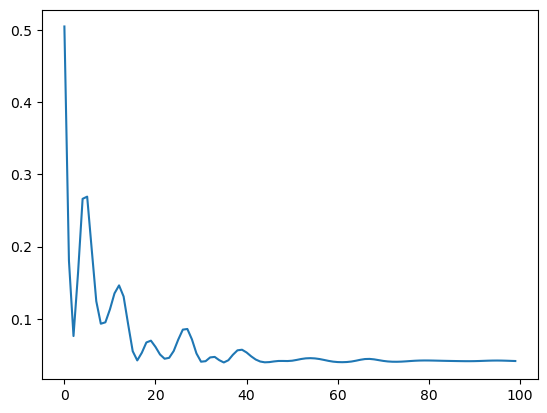

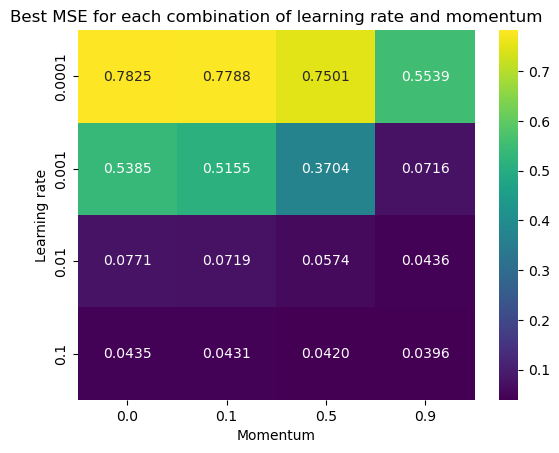

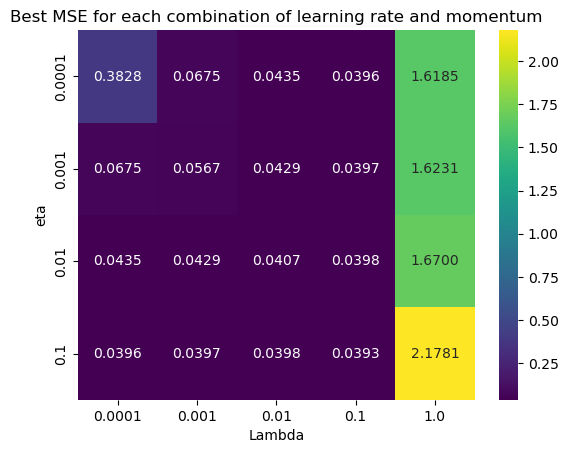

best gamma for each cell
[[0.9 0.9 0.9 0.9 0. ]
 [0.9 0.9 0.9 0.9 0. ]
 [0.9 0.9 0.9 0.9 0. ]
 [0.9 0.9 0.9 0.9 0. ]]


In [1486]:
import seaborn as sns


fig, ax = plt.subplots(1, 1)
ax.plot(scoresSgd[3,3,:])


plt.figure()
ax = sns.heatmap(np.min(scoresSgd,axis=2), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(gammas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(etas)
plt.show()



plt.figure()
ax = sns.heatmap(np.min(scoresRidge,axis=(1,3)), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Lambda")
ax.set_xticklabels(alphas)
ax.set_ylabel("eta")
ax.set_yticklabels(etas)
plt.show()



bestGamma = np.argmin(np.min(scoresRidge,axis=3),axis=1)
print("best gamma for each cell")
print(np.array((gammas,gammas))[0,bestGamma])

# Automatic differentiation

In [1478]:
from jax import grad

gradients = jax.jit(grad(MSE, argnums=0))
ridge_gradients = jax.jit(grad(MSE_Ridge, argnums=0))

In [1479]:
scoresAdagrad, scoresRmsprop, scoresAdam, scoresAdagradJax, scoresRmspropJax, scoresAdamJax, scoresHessianGd, scoresSgd, scoresSgdJax, scoresRidge, scoresRidgeJax = runSTG()

TypeError: HessianInvGD.__init__() got an unexpected keyword argument 'eta'

In [ ]:

all_momentum_scores = np.array((scoresSgd , scoresSgdJax ,scoresAdagrad, scoresAdagradJax ))
for scores in all_momentum_scores:
    ax = sns.heatmap(np.min(scores,axis=2), annot=True, fmt=".3f", cmap="viridis")
    plt.figure()
    ax.set_title("Best MSE for each combination of learning rate and momentum")
    ax.set_xlabel("Momentum")
    ax.set_xticklabels(gammas)
    ax.set_ylabel("Learning rate")
    ax.set_yticklabels(etas)
    plt.show()

scores_rest = np.array((scoresHessianGd, scoresRmsprop, scoresAdam, scoresRmspropJax, scoresAdamJax))
for scores in scores_rest:
    ax = sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis")
    plt.figure()
    ax.set_title("Best MSE for each combination of learning rate and momentum")
    ax.set_xlabel("Epochs")
    ax.set_xticklabels(np.linspace(0,epochs,25,dtype=int))
    ax.set_ylabel("Learning rate")
    ax.set_yticklabels(etas)
    plt.show()

ax = sns.heatmap(np.min(scoresRidge,axis=(0,3)), annot=True, fmt=".3f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(alphas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(gammas)
plt.show()

ax = sns.heatmap(np.min(scoresRidgeJax,axis=(0,3)), annot=True, fmt=".3f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(alphas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(gammas)
plt.show()

NameError: name 'scoresSgdJax' is not defined